# Visualizing Premier League Data (2)

##### Source for this data: https://www.bbc.com/sport/football/premier-league/table
---
We're looking at the premier league table to determine **possible** correlation between Goal Difference and Points

*Edit 1-27-26:* This data is no longer scrapable. Will construct table from scratch

In [4]:
#Libs:

import pandas as pd
import matplotlib.pyplot as plt

## Constructing Premier League Table:

In [5]:
raw_matches = pd.read_csv(r'../data/E0_2526.csv')

What we'll do here is take in match-level data and then output the league table (turning 1 row per match into 1 row per team.)

Every match gives us:
- Home team
- Away team
- Full-time home goals
- Full-time away goals

What we need is (schema for our dataframe):
- Team name
- Matches played by that team
- Matches won, drawn, and lost by that team
- Goals fowarded (scored)
- Goals allowed (conceded)
- Points (sum up 3 for win, 1 for tie, and 0 for loss)
- Form (Definitely do last 5 matches)

**Make sure to add up stats for the away team as well. Every match becomes two rows.** 

Further ideas: 
- Like njsports.com, they have "strength" rankings where they see how much a team beats another team and compare it with their predictions, and that residual will create "power points", which are averaged and then compared with other teams.

In [6]:
#testing
for index, row in raw_matches.iterrows():
    print(row['Date'], row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'])

15/08/2025 Liverpool Bournemouth 4 2
16/08/2025 Aston Villa Newcastle 0 0
16/08/2025 Brighton Fulham 1 1
16/08/2025 Sunderland West Ham 3 0
16/08/2025 Tottenham Burnley 3 0
16/08/2025 Wolves Man City 0 4
17/08/2025 Chelsea Crystal Palace 0 0
17/08/2025 Nott'm Forest Brentford 3 1
17/08/2025 Man United Arsenal 0 1
18/08/2025 Leeds Everton 1 0
22/08/2025 West Ham Chelsea 1 5
23/08/2025 Man City Tottenham 0 2
23/08/2025 Bournemouth Wolves 1 0
23/08/2025 Brentford Aston Villa 1 0
23/08/2025 Burnley Sunderland 2 0
23/08/2025 Arsenal Leeds 5 0
24/08/2025 Crystal Palace Nott'm Forest 1 1
24/08/2025 Everton Brighton 2 0
24/08/2025 Fulham Man United 1 1
25/08/2025 Newcastle Liverpool 2 3
30/08/2025 Chelsea Fulham 2 0
30/08/2025 Man United Burnley 3 2
30/08/2025 Sunderland Brentford 2 1
30/08/2025 Tottenham Bournemouth 0 1
30/08/2025 Wolves Everton 2 3
30/08/2025 Leeds Newcastle 0 0
31/08/2025 Brighton Man City 2 1
31/08/2025 Nott'm Forest West Ham 0 3
31/08/2025 Liverpool Arsenal 1 0
31/08/2025

In [ ]:
#loop through matches
from collections import defaultdict

#initialize raw data storage, schema will be like this:

# "team": [matches played, W, D, L, GF, GA, GD, Points, Last 5 results (tentative)]

raw_df = defaultdict(list)

for index, row in raw_matches.iterrows():
    print(row['Date'], row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'])

    #do something with the matches
    home_GF = row['FTHG']
    home_GA = row['FTAG']

    away_GA = row['FTAG']
    away_GF = row['FTHG']

    raw_df[row['HomeTeam']] += [0, 0, 0, 0, 0, 0, 0, 0, []] if len(raw_df[row['HomeTeam']]) == 0 else []

    



NameError: name 'raw_matches' is not defined

In [ ]:
# need to scrape premier league table data for more analysis
#creating scatter plot of goal diff. vs points

plt.figure(figsize=(8,6))
prem_table_df = pd.read_csv(r'../data/2526-prem-table-bbc.csv')

#rename columns for easier access
prem_table_df.rename(columns={'Goal Difference':'GD','Goals For':'GF', 'Goals Against':'GA'}, inplace=True)

prem_table_df = prem_table_df.rename(index = lambda x: x + 1)

prem_table_df.head()

,Team,Played,Won,Drawn,Lost,GF,GA,GD,Points,"Form, Last 6 games, Oldest first"
1,1Arsenal,22,15,5,2,40,14,26,50,WResult WinWResult WinWResult WinWResult WinDR...
2,2Manchester City,22,13,4,5,45,21,24,43,WResult WinWResult WinDResult DrawDResult Draw...
3,3Aston Villa,22,13,4,5,33,25,8,43,WResult WinWResult WinLResult LossWResult WinD...
4,4Liverpool,22,10,6,6,33,29,4,36,WResult WinWResult WinDResult DrawDResult Draw...
5,5Manchester United,22,9,8,5,38,32,6,35,LResult LossWResult WinDResult DrawDResult Dra...


<Figure size 800x600 with 0 Axes>

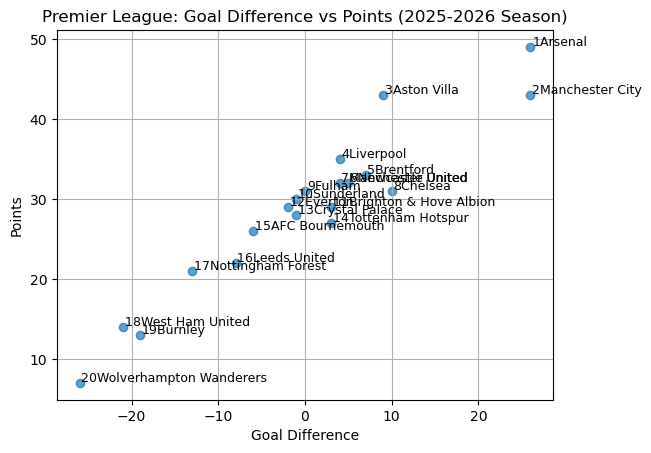

In [7]:
df = prem_table_df[['Team', 'Points', 'GD']]
plt.scatter(df['GD'], df['Points'], alpha=0.7)
plt.title('Premier League: Goal Difference vs Points (2025-2026 Season)')
plt.xlabel('Goal Difference')
plt.ylabel('Points')
for i, row in df.iterrows():
    plt.text(row['GD']+0.2, row['Points']+0.2, row['Team'], fontsize=9)
plt.grid(True)
plt.show()

There appears to be an almost perfect (very high) positive linear correlation between GD and points.